<a href="https://colab.research.google.com/github/mx-mn/image-reconstruction-cv23/blob/main/colab_train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

import keras
from keras.callbacks import Callback
from keras.layers import Input, Conv2D, Conv2DTranspose, Add, Activation
from keras.models import Model
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import math
from torch.utils.data import Dataset, DataLoader, TensorDataset
from pathlib import Path
import torch

print('GPU name: ', tf.config.experimental.list_physical_devices('GPU'))

base = Path.cwd() / 'drive' / 'MyDrive' / 'cvue23' / 'data'
base.exists()


Mounted at /content/drive
GPU name:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


True

In [ ]:

class DataGenerator(keras.utils.Sequence):
    def __init__(self, basedir, batch_size):

        paths = [f for f in basedir.iterdir() if f.is_file()]
        paths = list(sorted(paths, key=lambda x : int(str(x.stem).split('_')[-1])))
        self.files = [f.as_posix() for f in paths]
        self.batch_size = batch_size

    def load(self, path):
        loaded = np.load(path)
        x = loaded['x']/ 255
        y = loaded['y']/ 255
        return x, y

    def __len__(self):
        return math.ceil(len(self.files) / self.batch_size)

    def __getitem__(self, idx):
        low = idx * self.batch_size
        high = min(low + self.batch_size, len(self.files))
        batch = self.files[low:high]
        X, Y = [],[]
        for f in batch:
            x,y = self.load(f)
            X.append(x)
            Y.append(y)

        return np.concatenate(X), np.concatenate(Y)


datagen = DataGenerator((base / 'crop_1'), 16)

_x, _y = datagen[0]

_x.shape, _y.shape

((16, 128, 128, 6), (16, 128, 128))

In [ ]:
# for debugging
def plot_image_grid(images_array, grid_width=10, grid_height=10):

    if images_array.shape[0] != grid_width * grid_height:
        raise ValueError("The number of images does not match the grid size.")

    fig, axes = plt.subplots(grid_height, grid_width, figsize=(grid_width, grid_height))

    for i, ax in enumerate(axes.flatten()):
        ax.imshow(images_array[i], cmap='gray', interpolation='none')
        ax.axis('off')

    plt.tight_layout()
    plt.show()


def encoder(x, num_features, num_layers, residual_every=2):
    x = Conv2D(num_features, kernel_size=3, strides=2, padding='same', activation='relu')(x)

    # Save the output of conv layers at even indices
    residuals = []

    # Encoder
    for i in range(num_layers - 1):
        x = Conv2D(num_features, kernel_size=3, padding='same', activation='relu')(x)
        if (i + 1) % residual_every == 0:
            residuals.append(x)

    return x, residuals

def decoder(x, num_features, num_layers, residuals, residual_every=2):

    # Decoder
    for i in range(num_layers - 1):
        x = Conv2DTranspose(num_features, kernel_size=3, padding='same')(x)

        if (i + 1 + num_layers) % residual_every == 0 and residuals:
            res = residuals.pop()
            x = Add()([x, res])

        x = Activation('relu')(x)

    if residuals: raise ValueError('There are unused residual connections')

    # create 1-channel output
    x = Conv2DTranspose(1, kernel_size=3, strides=2, padding='same')(x)

    return x

def REDNet(num_layers, num_features, channel_size):
    '''Model definition with keras functional layers api'''

    inputs = Input(shape=(None, None, channel_size))

    x, residuals = encoder(inputs, num_features, num_layers)

    x = decoder(x, num_features, num_layers, residuals)

    # Add input residual, needed to do 1x1 conv to adapt channels
    residual = Conv2DTranspose(1, kernel_size=1, padding='same')(inputs)
    outputs = Add()([x, residual])
    outputs = Activation('relu')(outputs)

    # Create model
    model = Model(inputs=inputs, outputs=outputs, name=f'REDNet{num_layers*2}')
    return model

class PredictionCallback(Callback):
    def __init__(self, interval, x_val, y_val):
        super(PredictionCallback, self).__init__()
        self.interval = interval
        self.x_val = x_val
        self.y_val = y_val

    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.interval == 0:
            preds = self.model.predict(self.x_val).squeeze()
            plot_image_grid(np.concatenate([self.x_val[:,:,:,1], preds, self.y_val]), preds.shape[0], 3)

In [ ]:
def load_data(path):
  # load the mini dataset
  loaded = np.load(path)
  x, y, labels = loaded['x'], loaded['y'], loaded['labels']

  # normalize dataset
  assert y.max() == 255
  assert x.max() == 255

  y = y / 255
  x = x / 255
  return x, y, labels

x_val, y_val, _ = load_data(base / 'part_1_original_test_100.npz')

In [ ]:
# compile the model
model = REDNet(
    num_layers=9,
    num_features=64,
    channel_size=x_val.shape[-1]
)

opt = keras.optimizers.Adam(
    learning_rate=0.00001
)

loss = keras.losses.MeanSquaredError(
    reduction="sum_over_batch_size",
    name="mse"
)

prediction_callback = PredictionCallback(interval=2, x_val=x_val[:8], y_val=y_val[:8])
model.compile(loss=loss,optimizer=opt)

Epoch 1/20
164/164 [==============================] - ETA: 0s - loss: 0.0677

1/1 [==============================] - 0s 313ms/step


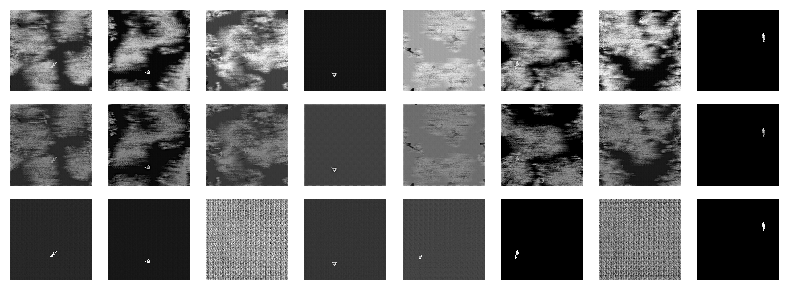

164/164 [==============================] - 45s 238ms/step - loss: 0.0677 - val_loss: 0.0377
Epoch 2/20
164/164 [==============================] - 30s 184ms/step - loss: 0.0404 - val_loss: 0.0358
Epoch 3/20
1/1 [==============================] - 0s 43ms/step


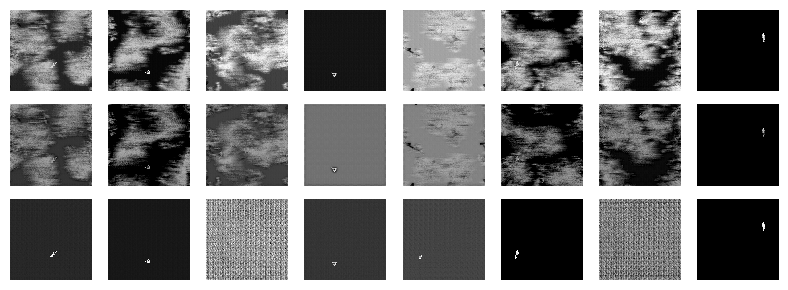

164/164 [==============================] - 37s 225ms/step - loss: 0.0374 - val_loss: 0.0307
Epoch 4/20
164/164 [==============================] - 25s 151ms/step - loss: 0.0325 - val_loss: 0.0250
Epoch 5/20
1/1 [==============================] - 0s 69ms/step


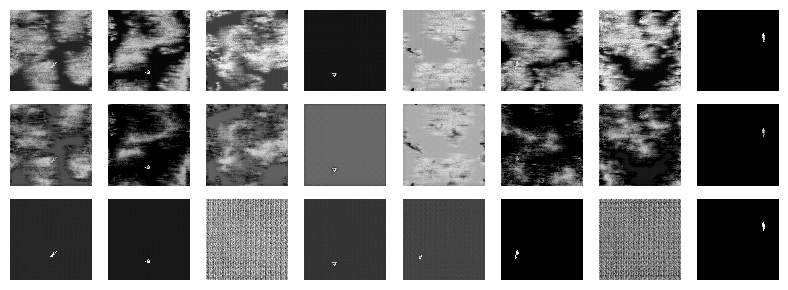

164/164 [==============================] - 26s 156ms/step - loss: 0.0278 - val_loss: 0.0210
Epoch 6/20
164/164 [==============================] - 27s 164ms/step - loss: 0.0245 - val_loss: 0.0235
Epoch 7/20
1/1 [==============================] - 0s 49ms/step


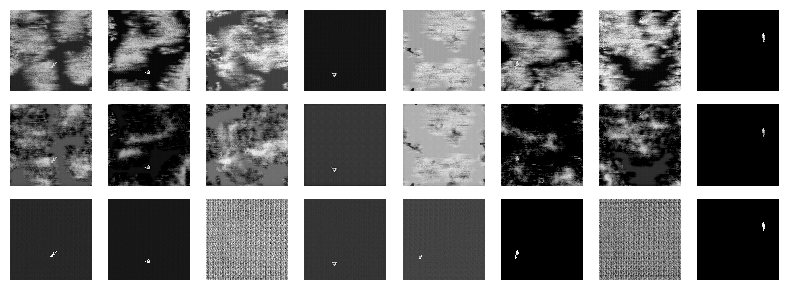

164/164 [==============================] - 26s 161ms/step - loss: 0.0218 - val_loss: 0.0165
Epoch 8/20
164/164 [==============================] - 25s 154ms/step - loss: 0.0211 - val_loss: 0.0166
Epoch 9/20
1/1 [==============================] - 0s 58ms/step


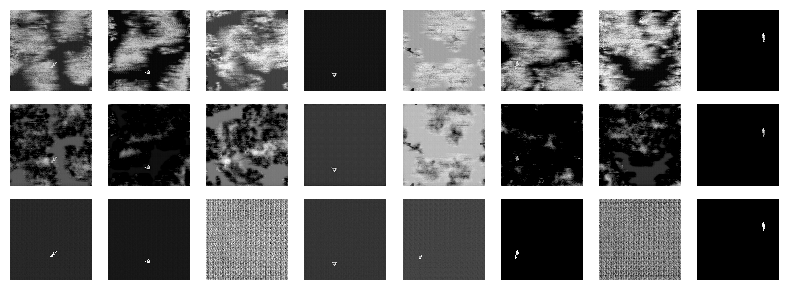

164/164 [==============================] - 26s 158ms/step - loss: 0.0195 - val_loss: 0.0197
Epoch 10/20
164/164 [==============================] - 24s 147ms/step - loss: 0.0194 - val_loss: 0.0159
Epoch 11/20
1/1 [==============================] - 0s 43ms/step


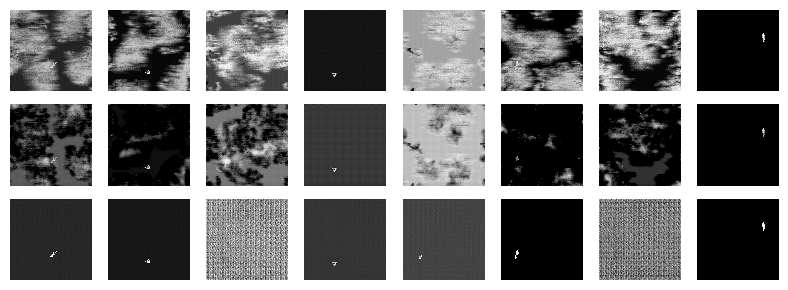

164/164 [==============================] - 27s 165ms/step - loss: 0.0186 - val_loss: 0.0195
Epoch 12/20
164/164 [==============================] - 26s 157ms/step - loss: 0.0180 - val_loss: 0.0149
Epoch 13/20
1/1 [==============================] - 0s 65ms/step


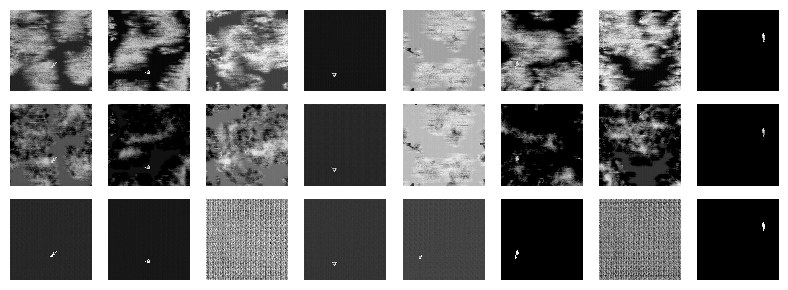

164/164 [==============================] - 27s 163ms/step - loss: 0.0179 - val_loss: 0.0143
Epoch 14/20
164/164 [==============================] - 25s 150ms/step - loss: 0.0173 - val_loss: 0.0151
Epoch 15/20
1/1 [==============================] - 0s 57ms/step


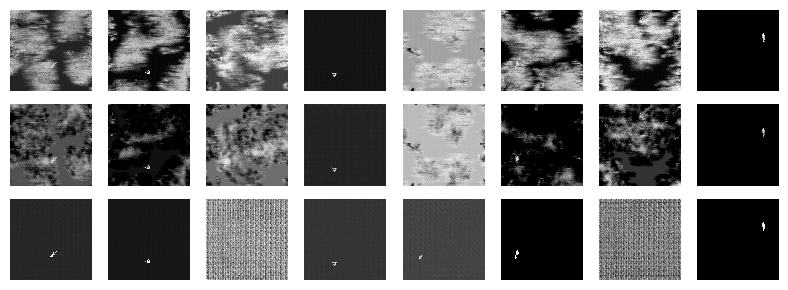

164/164 [==============================] - 28s 167ms/step - loss: 0.0175 - val_loss: 0.0137
Epoch 16/20
164/164 [==============================] - 25s 150ms/step - loss: 0.0172 - val_loss: 0.0162
Epoch 17/20
1/1 [==============================] - 0s 57ms/step


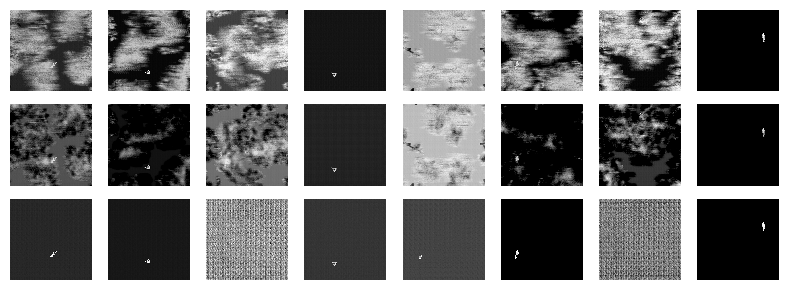

164/164 [==============================] - 26s 159ms/step - loss: 0.0164 - val_loss: 0.0136
Epoch 18/20
164/164 [==============================] - 25s 152ms/step - loss: 0.0166 - val_loss: 0.0136
Epoch 19/20
1/1 [==============================] - 0s 45ms/step


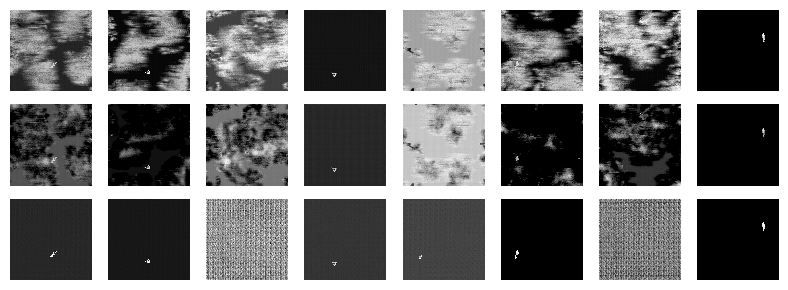

164/164 [==============================] - 28s 169ms/step - loss: 0.0175 - val_loss: 0.0155
Epoch 20/20
164/164 [==============================] - 26s 157ms/step - loss: 0.0169 - val_loss: 0.0185


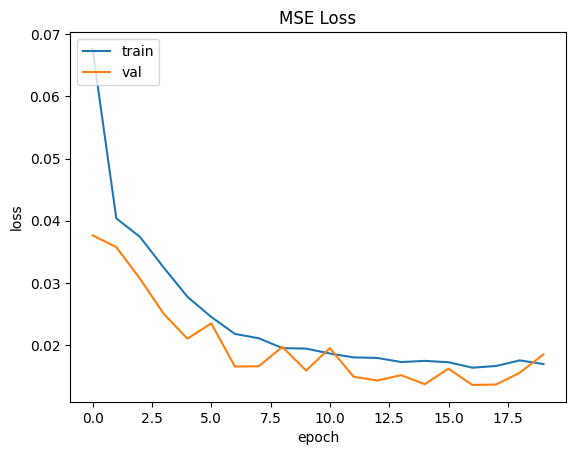

In [ ]:
# train on the dataset
history = model.fit(
    x=DataGenerator(paths, 32),
    epochs=20,
    validation_data=(x_val, y_val),
    callbacks=[prediction_callback],
    shuffle=True,
)
# Save the weights
model.save_weights(base.parent / 'models' / 'new_2')

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('MSE Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()